In [1]:
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
import numpy as np
from scipy.optimize import curve_fit
import tikzplotlib

In [2]:
ACMBlue = '#00cfe6'
ACMYellow = '#ffd600'
ACMOrange = '#fc9200'
ACMRed = '#ff1924'
ACMLightBlue = '#82fcff'
ACMGreen = '#a5cf00'
ACMPurple = '#6200d9'
ACMDarkBlue = '#0055c9'
    
    
def setup_ax(ax, mark_study_c=False):
    if mark_study_c:
        ax.axvline(pd.Timestamp('1995-01-01'), linestyle='dotted', color='gray')
        ax.axvline(pd.Timestamp('2007-01-01'), linestyle='dotted', color='gray')
    
    locator = mdates.YearLocator()
    ax.xaxis.set_minor_locator(locator)
    ax.set_xticks(pd.DatetimeIndex(['{}-01-01'.format(year) for year in range(1992, 2021, 2)]))
    year_fmt = mdates.DateFormatter('%Y')
    ax.xaxis.set_major_formatter(year_fmt)
    
    ax.grid(linestyle='dotted', which='both')
    ax.set_xlim(left=pd.Timestamp('1991-01-01'), right=pd.Timestamp('2021-01-01'))
    

def exp_fit(y_data):
    def _exp(t, a, b, c):
        return a*np.exp(b*t) + c
    
    x_data = range(0, len(y_data))
    
    params, params_covariance = curve_fit(_exp, x_data, y_data, p0=[0, 0, 0])
    y_fit = _exp(x_data, params[0], params[1], params[2])
    return y_fit, params

plt.rcParams.update({
    'font.family': 'sans-serif', 
    'text.usetex': False,
    'pgf.rcfonts': False, # was false
    'mathtext.fontset': 'stixsans'
})

default_ratio = (np.sqrt(5.0) - 1.0) / 2.0
default_width = 6
default_height = default_ratio * default_width

In [3]:
activities = pd.read_hdf('../data/openhub.h5', key='filled_activities', mode='r')
activities.shape

(6011057, 8)

# Outliers

![alt text](https://upload.wikimedia.org/wikipedia/commons/thumb/2/25/The_Normal_Distribution.svg/1920px-The_Normal_Distribution.svg.png)

In [4]:
activities['loc_added'] = activities.code_added + activities.comments_added

In [5]:
code_added = activities.loc_added[activities.loc_added.transform(lambda x: (x - x.mean()) / x.std()).abs()<=3]
commits = activities.commits[activities.commits.transform(lambda x: (x - x.mean()) / x.std()).abs()<=3]
contributors = activities.contributors[activities.contributors.transform(lambda x: (x - x.mean()) / x.std()).abs()<=3]

# Outliers' impact

In [6]:
activities.index.get_level_values(1).nunique()

172833

In [7]:
activities.code_added.sum(), activities.code_added.sum()-code_added.sum(), code_added.max()

(34487694594, 13045874360, 553097)

In [8]:
activities.commits.sum(), activities.commits.sum()-commits.sum(), commits.max()

(114794355, 29272733, 708)

In [9]:
activities.contributors.sum(), activities.contributors.sum()-contributors.sum(), contributors.max()

(8549545, 2542617, 26)

# Commits

In [10]:
commits_per_month = commits.groupby(level=[0]).sum()

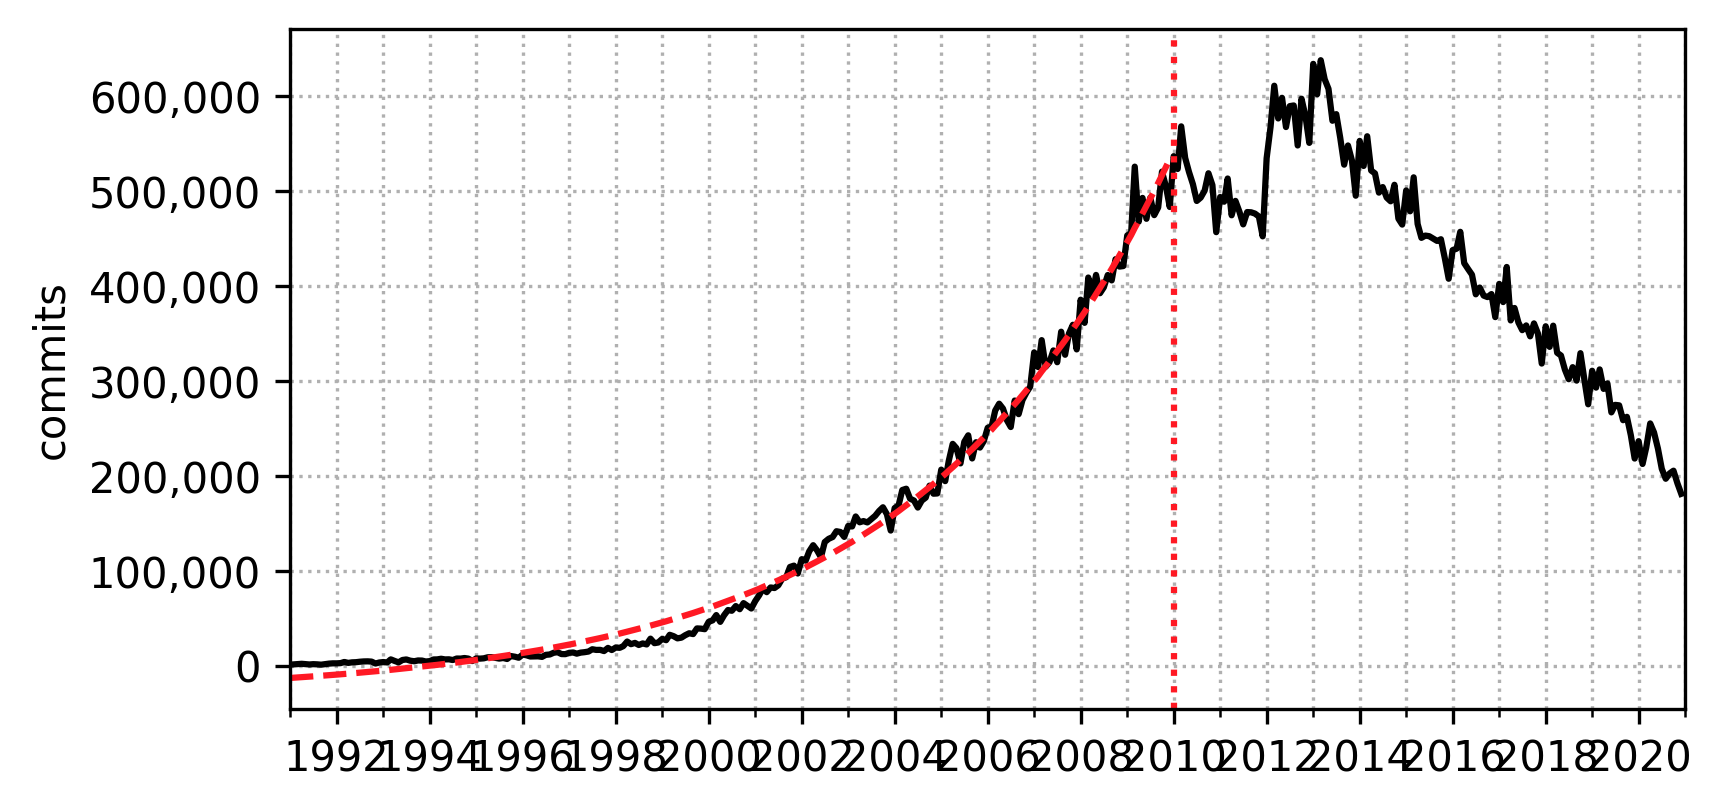

In [11]:
exp_fit_end = (2010-1991)*12
y_fit, params = exp_fit(commits_per_month[0:exp_fit_end])

fig = plt.figure(figsize=(default_width, 0.5*default_width), dpi=300)
ax = fig.add_subplot()

ax.plot(commits_per_month, label='Commits per month', color='black')

ax.plot(commits_per_month.index[:exp_fit_end], y_fit, color=ACMRed, linestyle='dashed', label='Exponential model')
ax.axvline(commits_per_month.index[exp_fit_end], linestyle='dotted', color=ACMRed)

setup_ax(ax)

ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_ylabel('commits')

plt.savefig('../reports/commits.pgf', bbox_inches='tight', pad_inches=0)

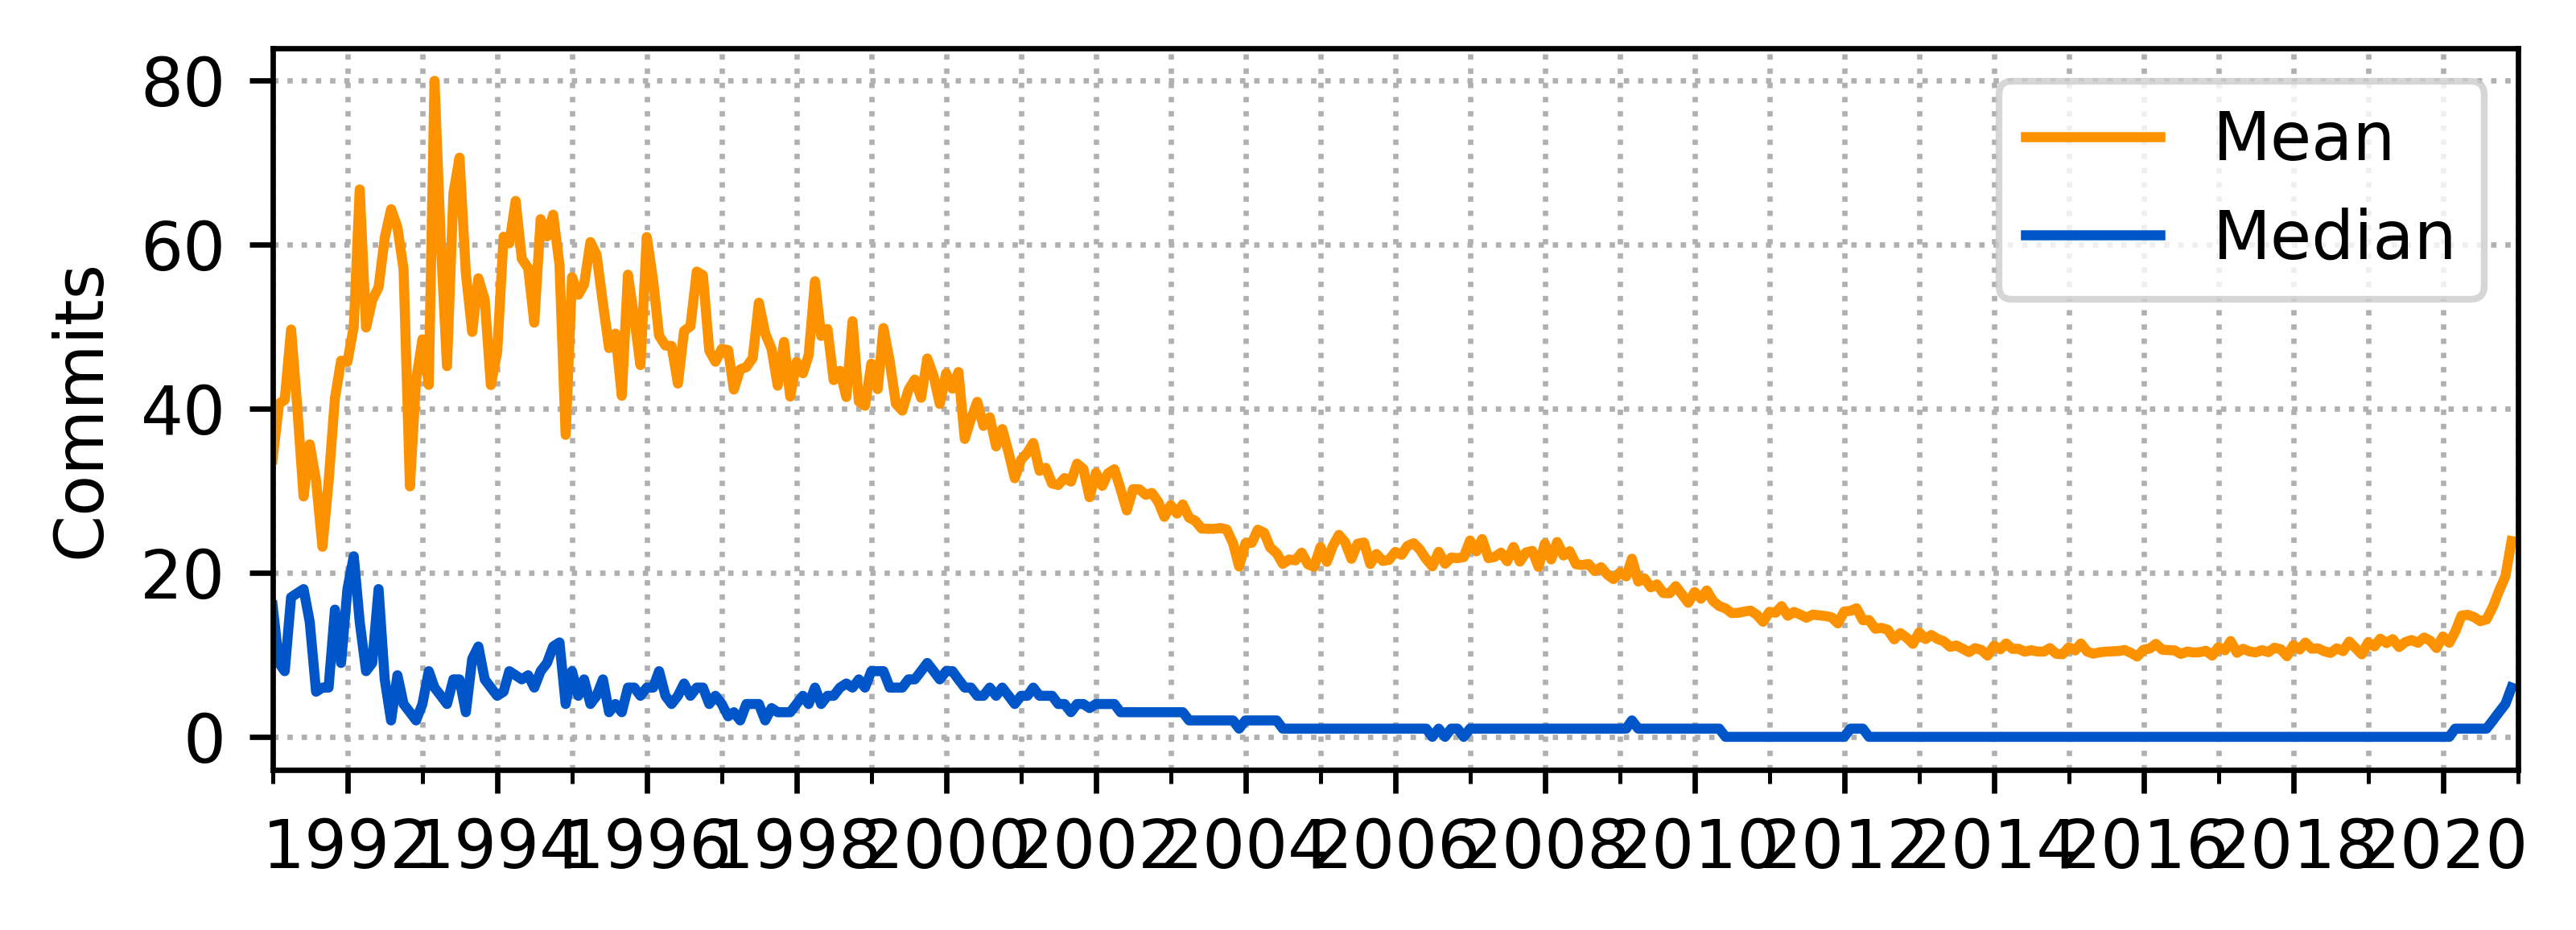

In [12]:
fig, ax = plt.subplots(figsize=(default_width, 0.33*default_width), dpi=600)

ax.plot(commits.groupby(level=0).mean(), label='Mean', color=ACMOrange)
ax.plot(commits.groupby(level=0).median(), label='Median', color=ACMDarkBlue)

setup_ax(ax)
ax.set_ylabel('Commits');
ax.legend(loc='upper right');

plt.savefig('../reports/average_commits.pgf', bbox_inches='tight', pad_inches=0)

# Contributors

In [13]:
contributors_per_month = contributors.groupby(level=[0]).sum()

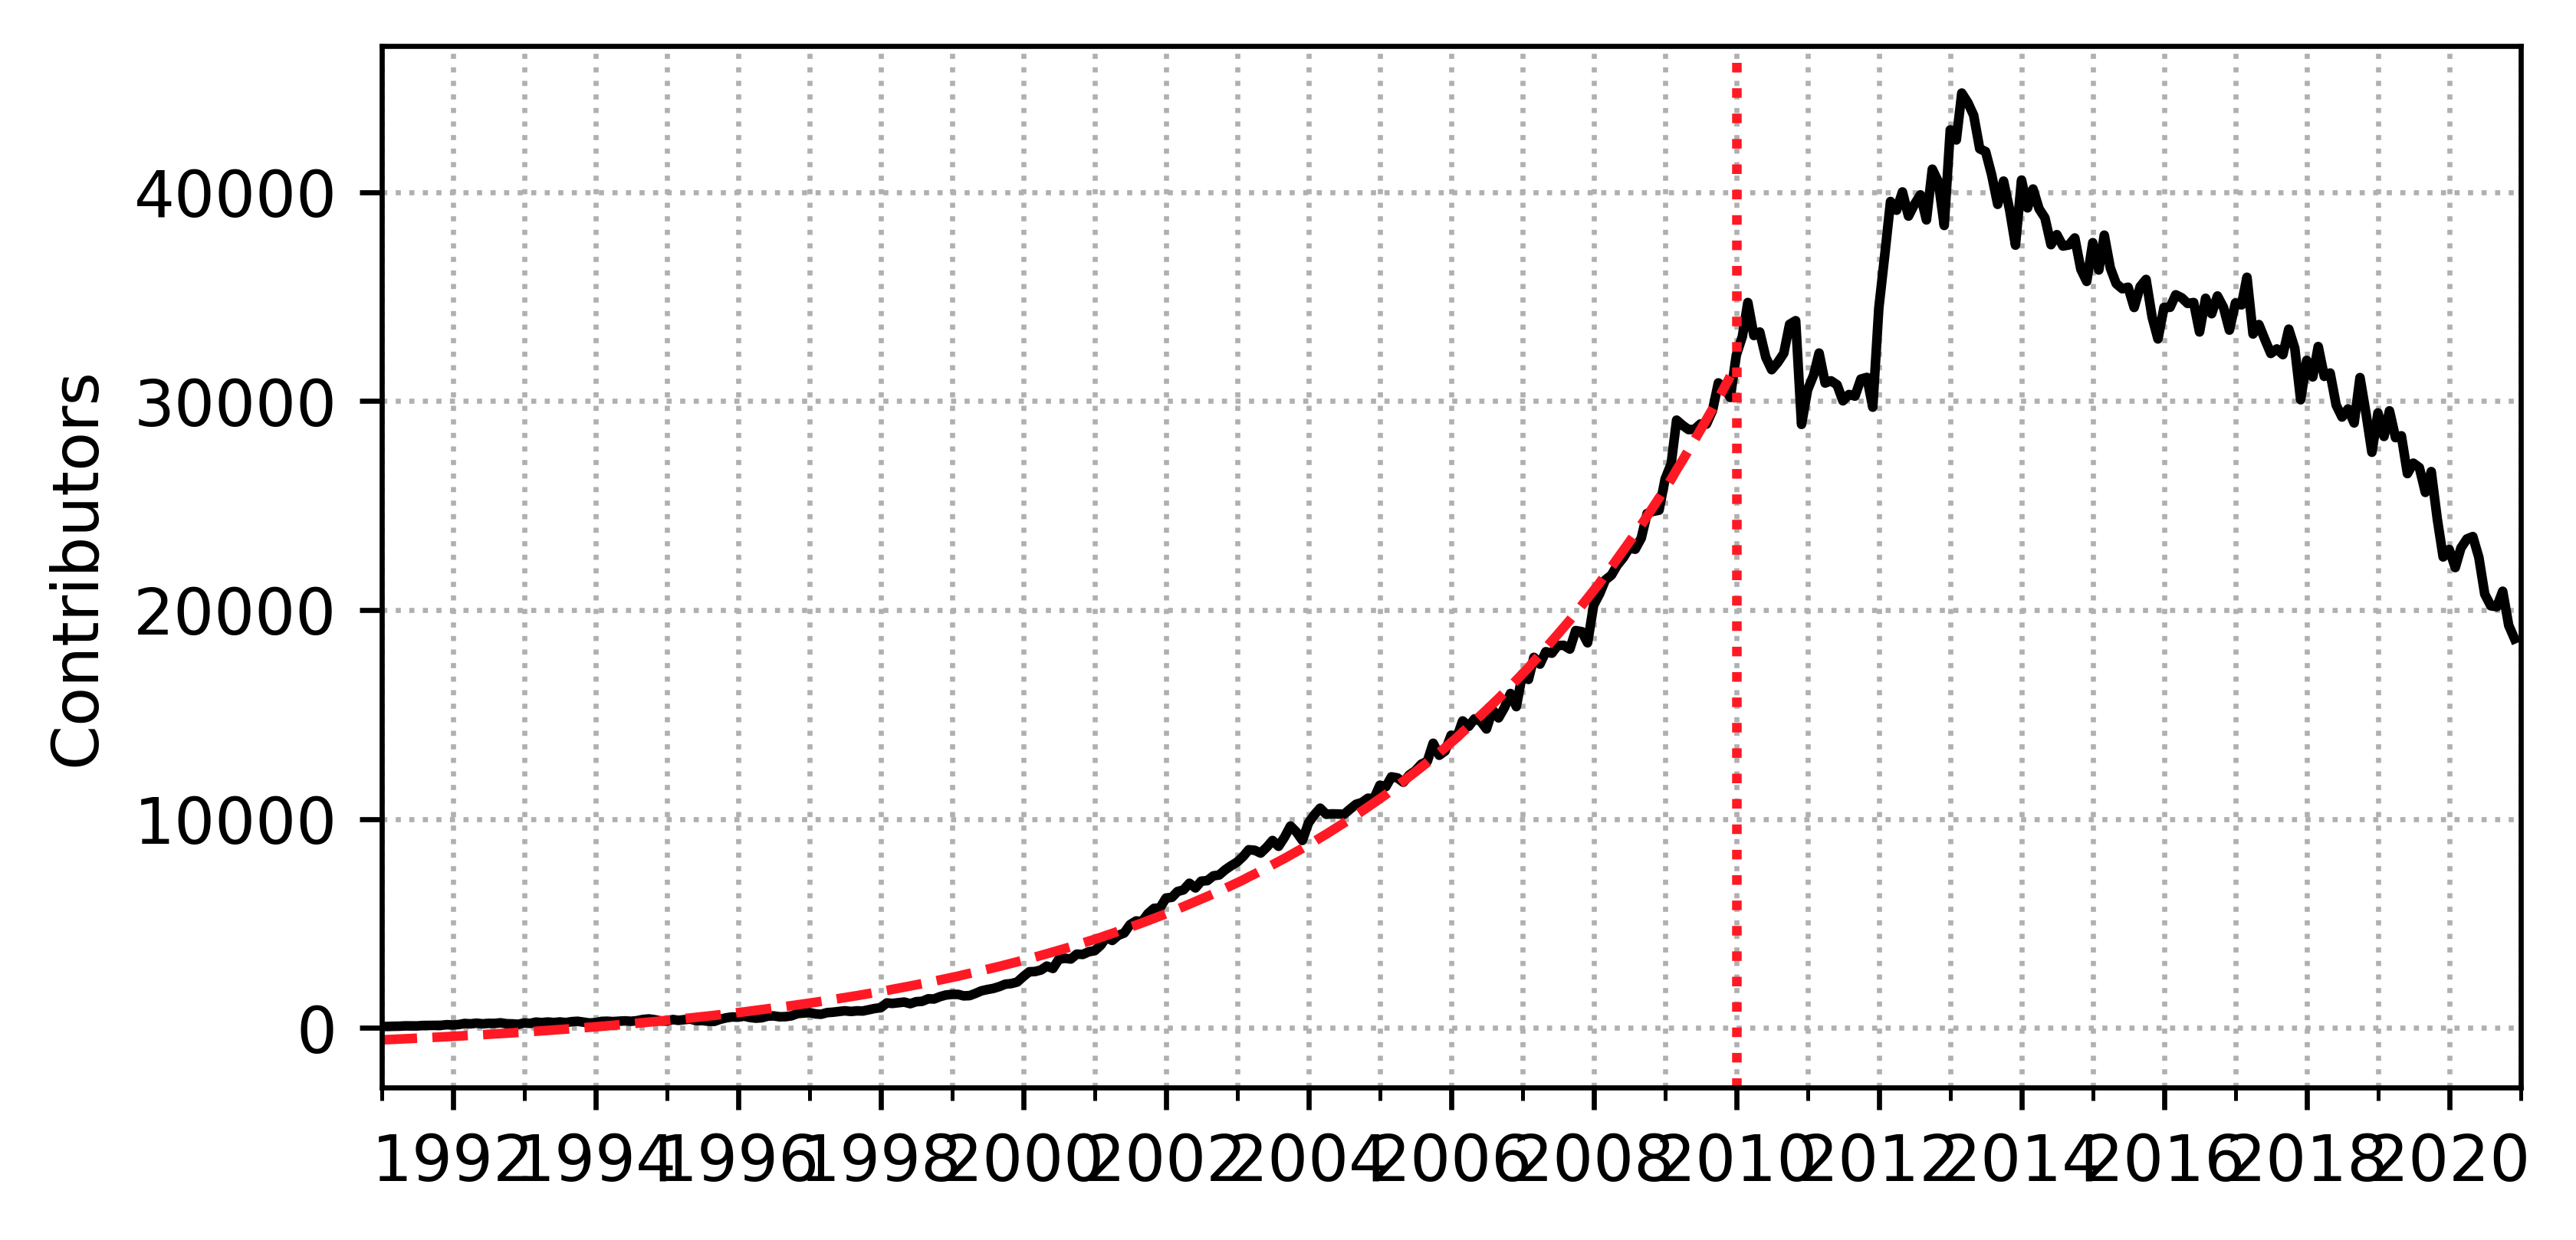

In [14]:
exp_fit_end = (2010-1991)*12
y_fit, params = exp_fit(contributors_per_month[:exp_fit_end])

fig, ax = plt.subplots(figsize=(default_width, 0.5*default_width), dpi=600)

ax.plot(contributors_per_month, label='Total contributors', color='black')

ax.plot(contributors_per_month.index[:exp_fit_end], y_fit, color=ACMRed, linestyle='dashed', label='Exponential model')
ax.axvline(contributors_per_month.index[exp_fit_end], linestyle='dotted', color=ACMRed, label='sd')

setup_ax(ax)
ax.set_ylabel('Contributors')

plt.savefig('../reports/contributors.pgf', bbox_inches='tight', pad_inches=0)

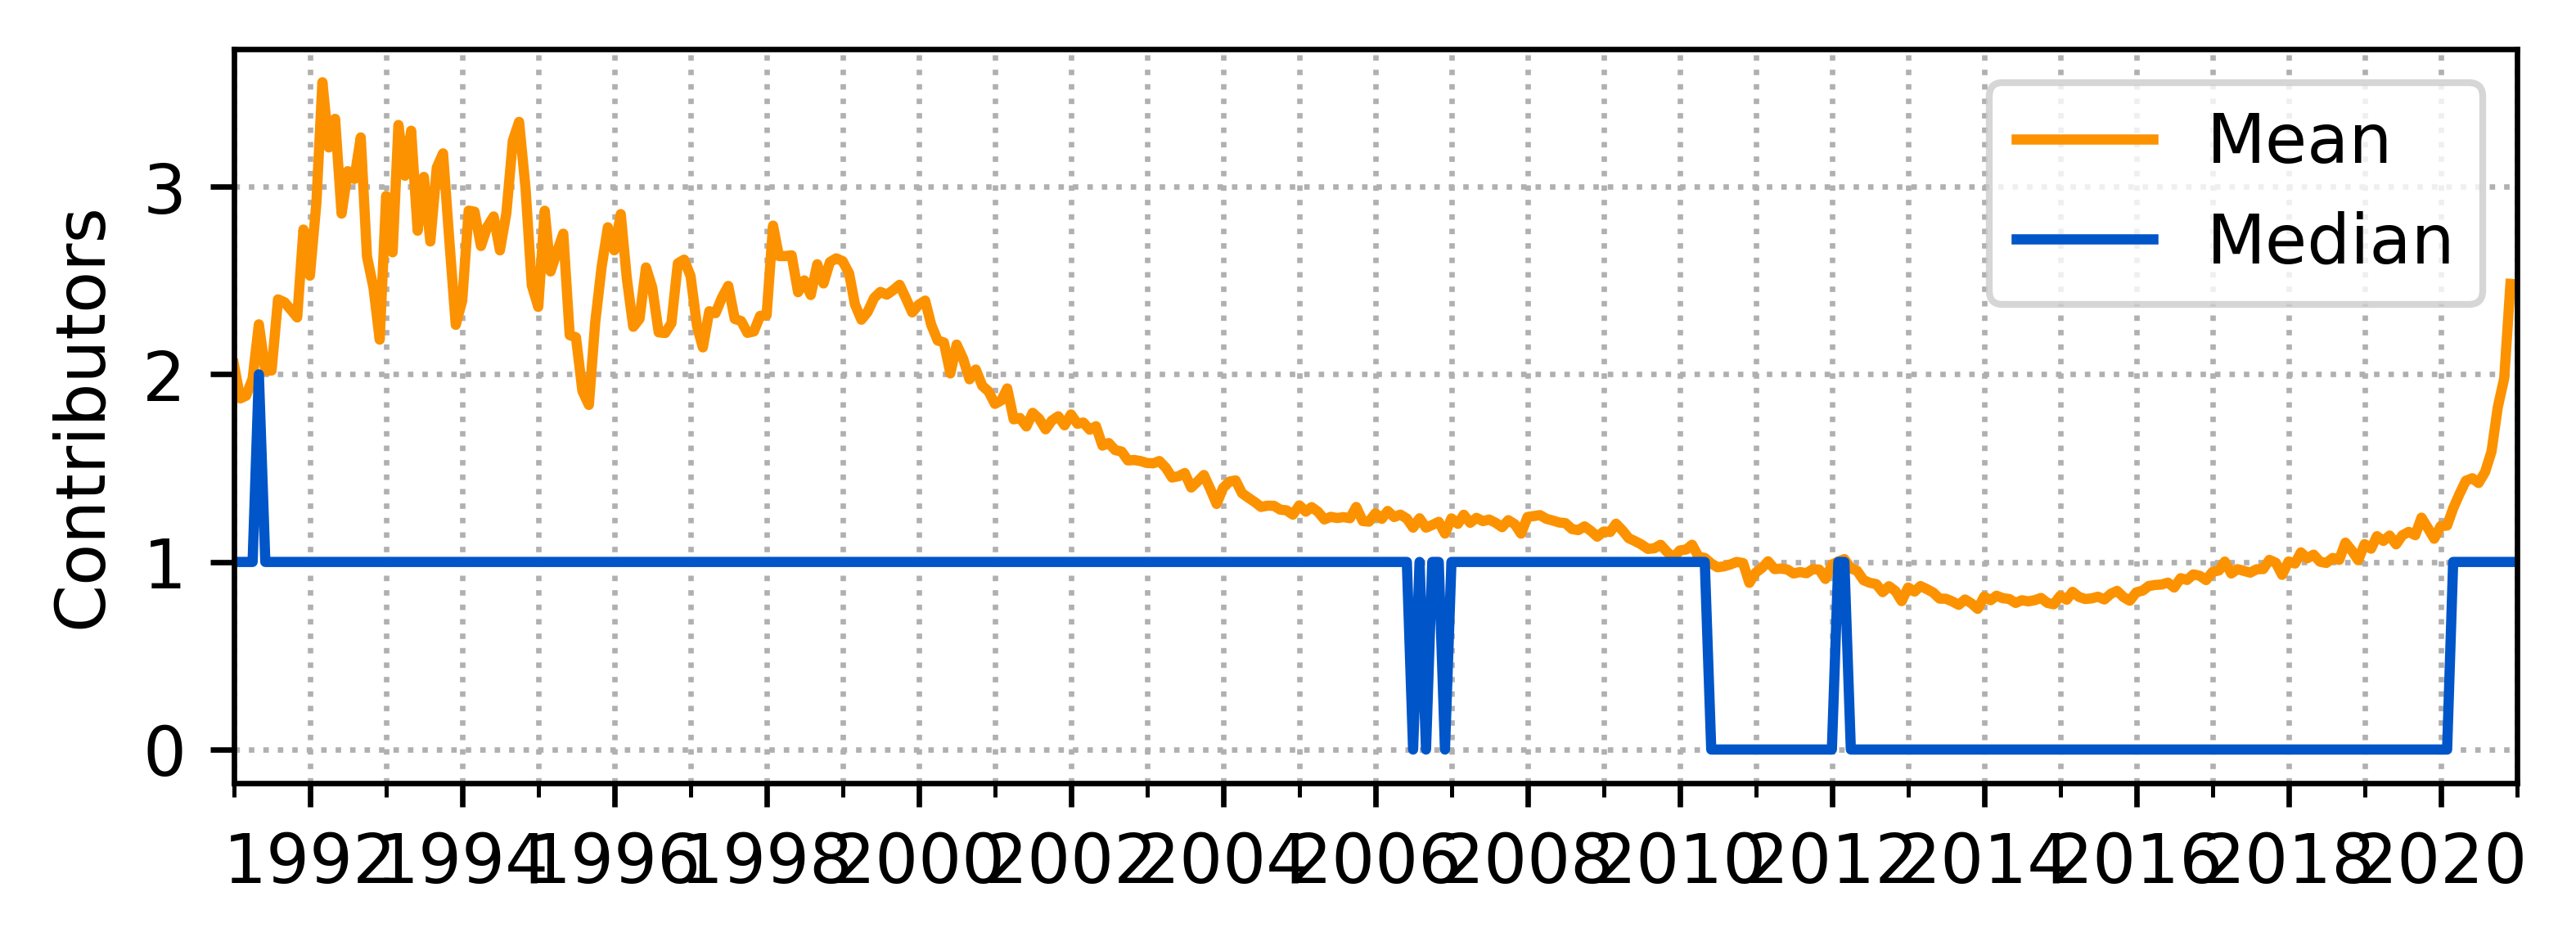

In [15]:
fig, ax = plt.subplots(figsize=(default_width, 0.33*default_width), dpi=600)

ax.plot(contributors.groupby(level=[0]).mean(), label='Mean', color=ACMOrange)
ax.plot(contributors.groupby(level=[0]).median(), label='Median', color=ACMDarkBlue)

setup_ax(ax)
ax.set_ylabel('Contributors');
ax.legend(loc='upper right');

plt.savefig('../reports/average_contributors.pgf', bbox_inches='tight', pad_inches=0)

# LoC

In [16]:
loc_per_month = code_added.groupby(level=0).sum()

In [17]:
exp_fit_end = (2010-1991)*12
y_fit, params = exp_fit(loc_per_month[:exp_fit_end])

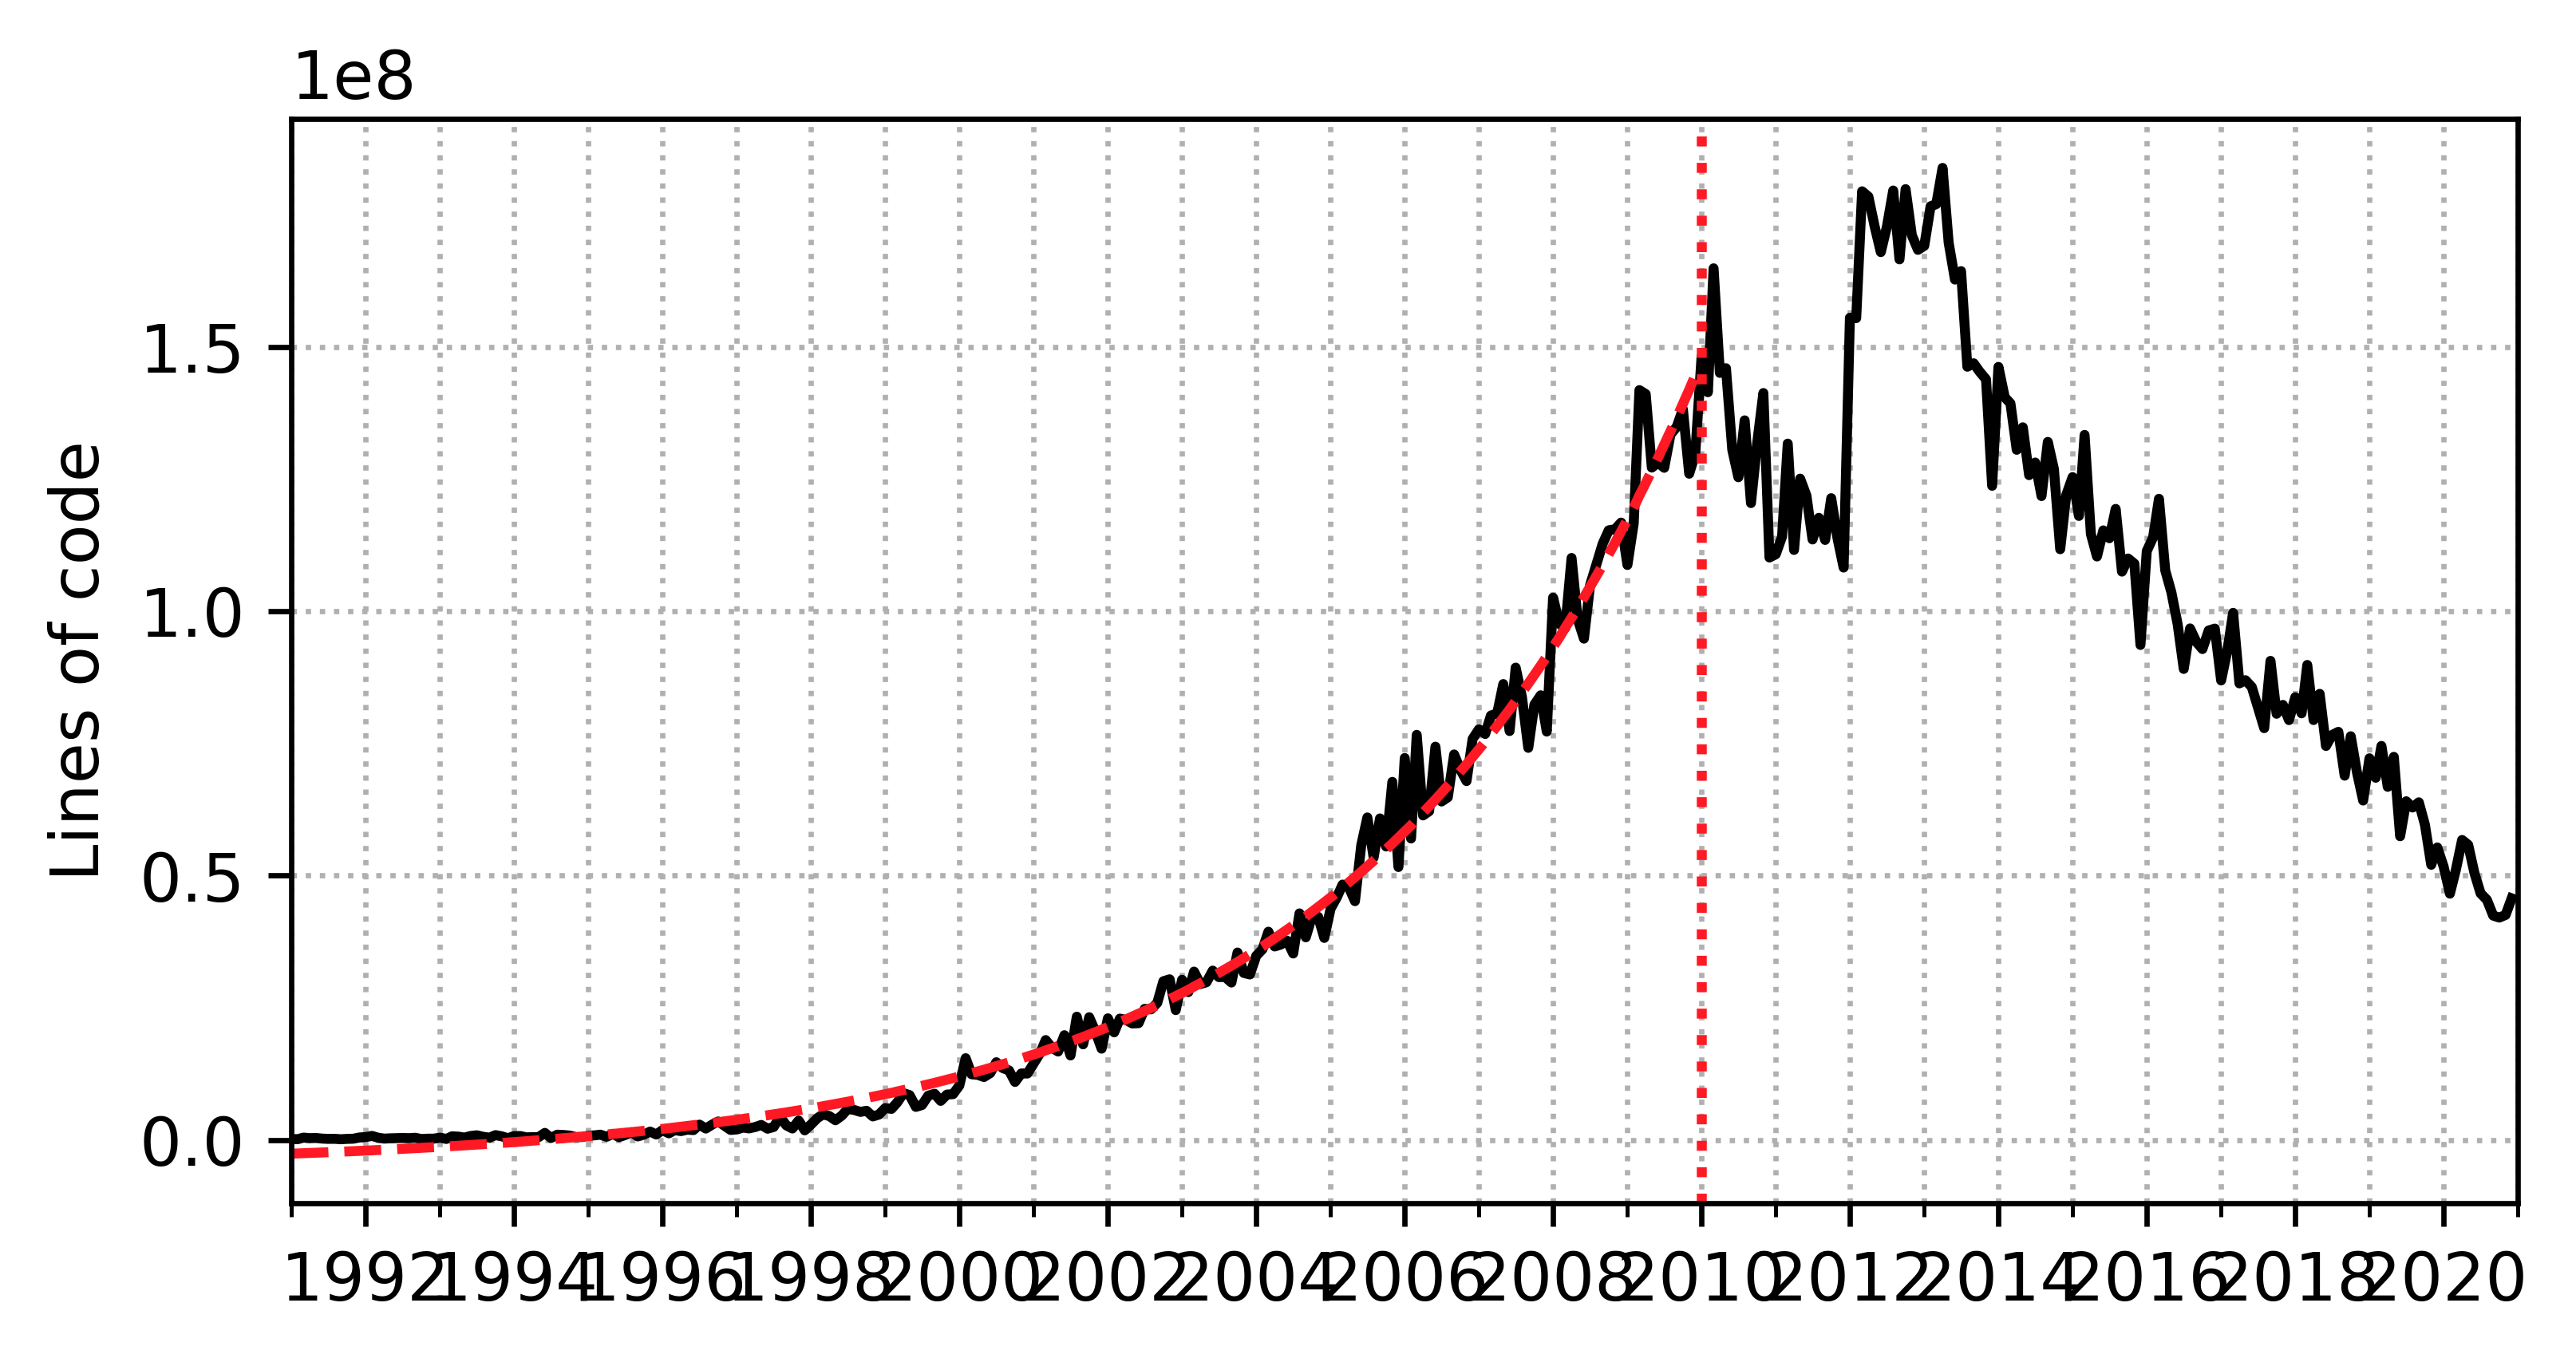

In [18]:
fig = plt.figure(figsize=(default_width, 0.5*default_width), dpi=600)
ax = fig.add_subplot()

ax.plot(loc_per_month, label='Mean', color='black')

ax.plot(loc_per_month.index[:exp_fit_end], y_fit, color=ACMRed, linestyle='dashed', label='Exponential model for lines of code')
ax.axvline(loc_per_month.index[exp_fit_end], linestyle='dotted', color=ACMRed)
    
setup_ax(ax)

#ax.legend(loc='upper left')
ax.set_ylabel('Lines of code');

plt.savefig('../reports/loc.pgf', bbox_inches='tight', pad_inches=0)

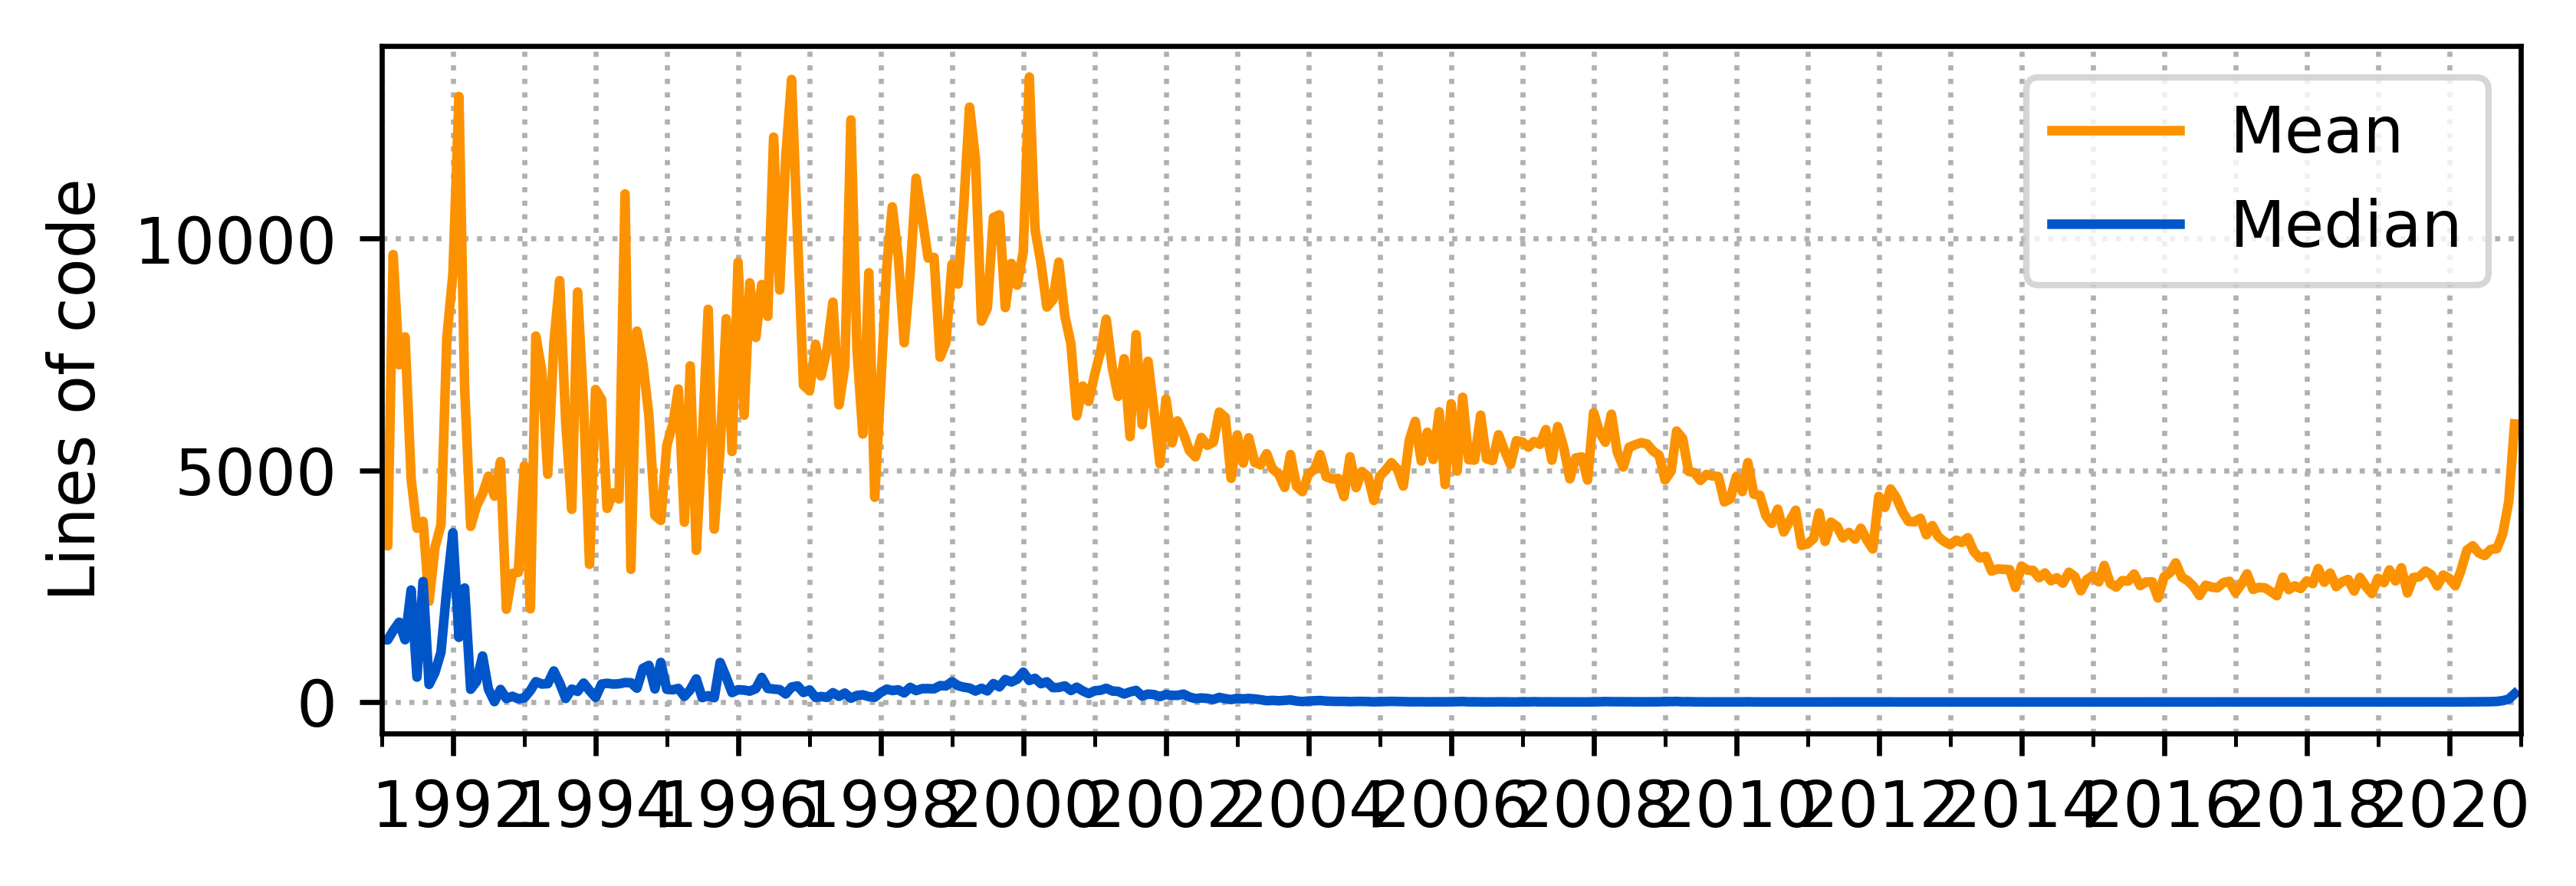

In [19]:
fig, ax = plt.subplots(figsize=(default_width, 0.33*default_width), dpi=600)

ax.plot(code_added.groupby(level=0).mean(), label='Mean', color=ACMOrange)
ax.plot(code_added.groupby(level=0).median(), label='Median', color=ACMDarkBlue)

setup_ax(ax)
ax.set_ylabel('Lines of code');
ax.legend(loc='upper right');

plt.savefig('../reports/average_loc.pgf', bbox_inches='tight', pad_inches=0)

# Lifecycle

In [20]:
valid_projects = pd.read_hdf('../data/openhub.h5', key='valid_projects', mode='r')

In [21]:
valid_projects.dtypes

updated_at    datetime64[ns]
min_month     datetime64[ns]
max_month     datetime64[ns]
dtype: object

In [22]:
last_active_month = dict(activities.commits.reset_index().groupby('project_id').month.max())

In [23]:
projects_index = activities.index.get_level_values(0).unique()

In [24]:
projects = activities.reset_index(level=1).project_id.groupby(level=[0]).nunique().reindex(projects_index, fill_value=0)

In [25]:
projects_active = activities[activities.commits>0].reset_index(level=1).project_id.groupby(level=[0]).nunique().reindex(projects_index, fill_value=0)

In [26]:
projects_inactive = activities[activities.commits==0].reset_index(level=1).project_id.groupby(level=[0]).nunique().reindex(projects_index, fill_value=0)

In [27]:
s = activities[activities.commits>0].reset_index(level=0).month.groupby(level=0).max() + pd.DateOffset(months=1)
projects_abandoned = pd.Series(s.index, index=s.values).groupby(level=0).nunique().reindex(projects_index, fill_value=0)

In [28]:
s = valid_projects.updated_at + pd.DateOffset(months=1)
projects_deleted = pd.Series(s.index, index=s.values).resample('MS').nunique().loc[:pd.Timestamp('2020-12-01')].reindex(projects_index, fill_value=0)

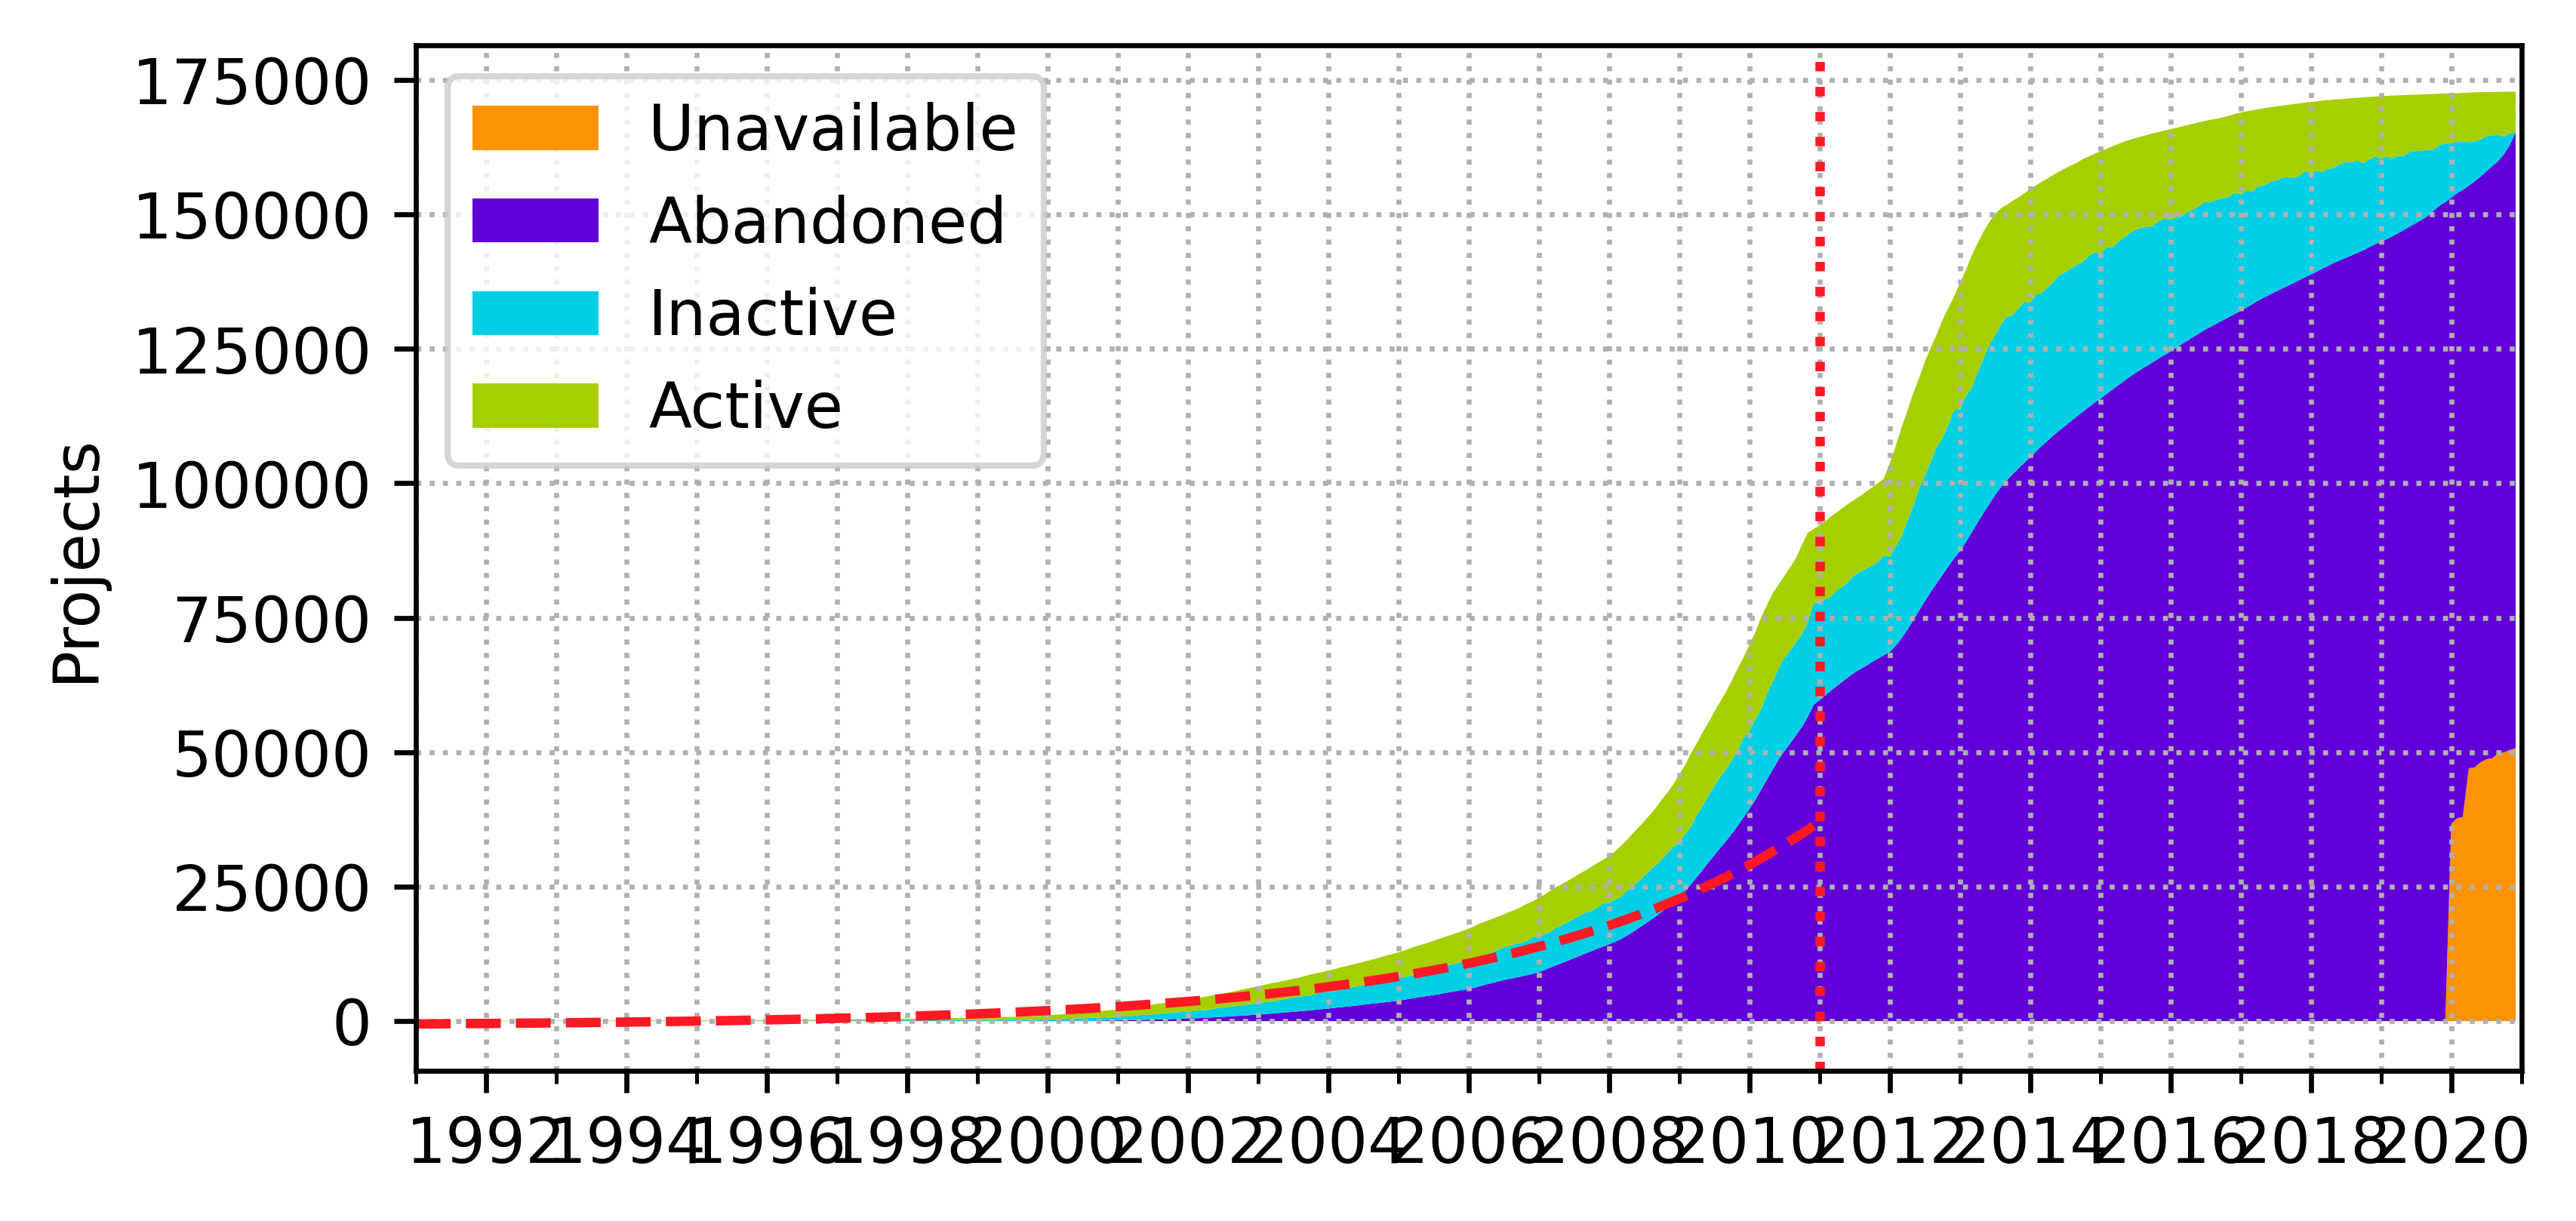

In [29]:
y_fit_end = (2011-1991)*12
y_fit, params = exp_fit(projects[:y_fit_end])
fig, ax = plt.subplots(figsize=(default_width, 0.5*default_width), dpi=600)

ax.stackplot(projects_index,  projects_deleted.cumsum(), projects_abandoned.cumsum()-projects_deleted.cumsum(), projects_inactive, projects_active, labels=['Unavailable', 'Abandoned', 'Inactive', 'Active'], colors=[ACMOrange, ACMPurple, ACMBlue, ACMGreen])

ax.plot(projects_index[0:y_fit_end], y_fit, color=ACMRed, linestyle='dashed')
ax.axvline(projects_index[y_fit_end], linestyle='dotted', color=ACMRed)

ax.legend(loc='upper left')
ax.set_ylabel('Projects')

setup_ax(ax)

plt.savefig('../reports/lifecycle.pgf', bbox_inches='tight', pad_inches=0)

In [30]:
s = valid_projects.min_month.reset_index(level=0).min_month.groupby(level=0).min()
projects_new = pd.Series(s.index, index=s.values).groupby(level=0).nunique().reindex(projects_index, fill_value=0)

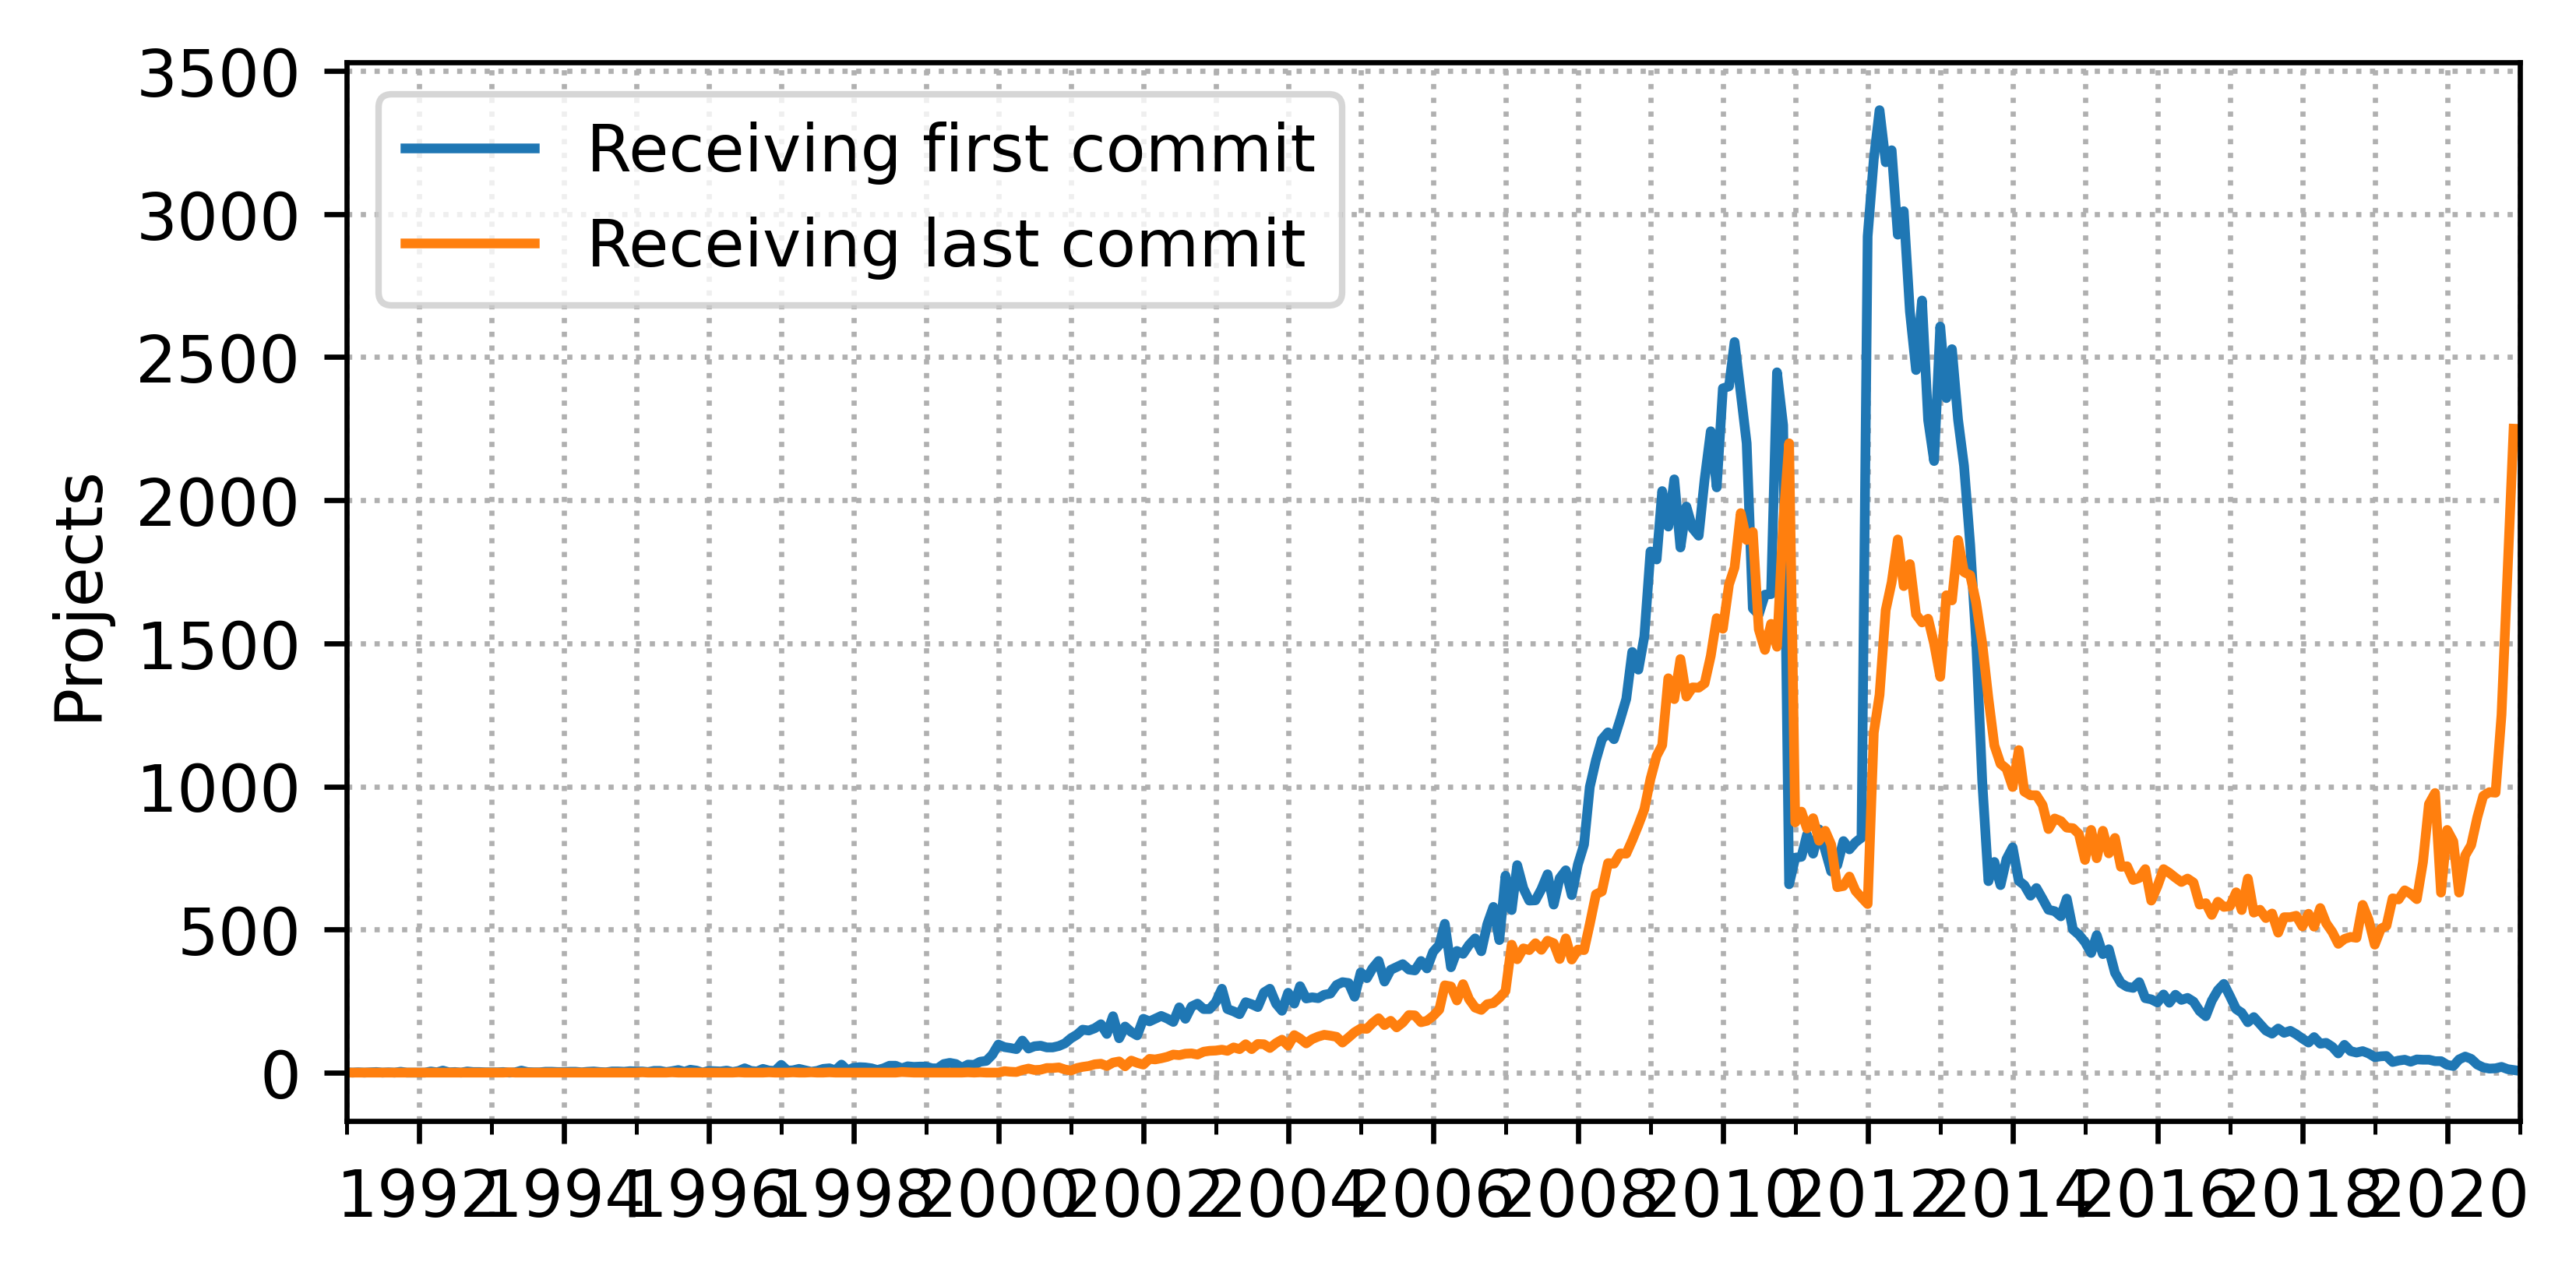

In [31]:
fig, ax = plt.subplots(figsize=(default_width, 0.5*default_width), dpi=600)

ax.plot(projects_new, label='Receiving first commit')
ax.plot(projects_abandoned, label='Receiving last commit')

ax.legend(loc='upper left')
ax.set_ylabel('Projects')

setup_ax(ax)
plt.savefig('../reports/first_last_commit.pgf', bbox_inches='tight', pad_inches=0)